<a href="https://colab.research.google.com/github/sjoon0305/KSME2026/blob/main/5. Hard_constraint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Description
- 풀어볼 문제는 다음과 같다.

	$$u'' + 39.48 u= 0 $$

- Boundary condition
$$
u(0)=u(1)=0
$$

- Data
$$
u(0.1)=0.588
$$

- Analytic solution
$$
\quad u_{sol}(x)=\sin \left( {2\pi x} \right)
$$

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.autograd as autograd
import matplotlib.pyplot as plt

# 신경망 정의
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.layers(x) # w/o hard constraint

# 물리 기반 잔차 계산
def pde_residual(net, x):
    x.requires_grad_(True)
    u = net(x)
    u_x = autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_xx = autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
    res = u_xx + 39.48 * u
    return res

# Exact solution
def true_func(x):
    return np.sin(2*np.pi*x)

# 학습
def train():
    net = Net()
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
    
    for epoch in range(10000):
        x_interior = torch.linspace(0, 1, 100).view(-1, 1)
        x_interior = x_interior[1:-1]  # 내부점만 사용

        # PDE loss
        residual = pde_residual(net, x_interior)
        loss_pde = torch.mean(residual**2)

        # 경계 조건 (Dirichlet)
        bc_left = net(torch.tensor([[0.0]]))
        bc_right = net(torch.tensor([[1.0]]))
        loss_bc = bc_left.pow(2) + bc_right.pow(2)

        # 데이터 조건
        data_x = torch.tensor([[0.1]])
        data_u = torch.tensor([[0.588]])
        pred_u = net(data_x)
        loss_data = torch.mean((pred_u - data_u)**2)

        # 전체 loss
        loss = loss_pde + loss_bc + loss_data

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")
            
    return net

# 결과 시각화
net = train()
x_test = torch.linspace(0, 1, 200).view(-1, 1)
u_pred = net(x_test).detach().numpy()
y_true = true_func(x_test.detach().numpy())


Epoch 0, Loss: 19.718840
Epoch 500, Loss: 0.345456
Epoch 1000, Loss: 0.345292
Epoch 1500, Loss: 0.345067
Epoch 2000, Loss: 0.344790
Epoch 2500, Loss: 0.344464
Epoch 3000, Loss: 0.344091
Epoch 3500, Loss: 0.420837
Epoch 4000, Loss: 0.343406
Epoch 4500, Loss: 0.343082
Epoch 5000, Loss: 0.349156
Epoch 5500, Loss: 0.342407
Epoch 6000, Loss: 0.398994
Epoch 6500, Loss: 0.341488
Epoch 7000, Loss: 0.406279
Epoch 7500, Loss: 0.339000
Epoch 8000, Loss: 0.362983
Epoch 8500, Loss: 0.329805
Epoch 9000, Loss: 0.328756
Epoch 9500, Loss: 0.327792


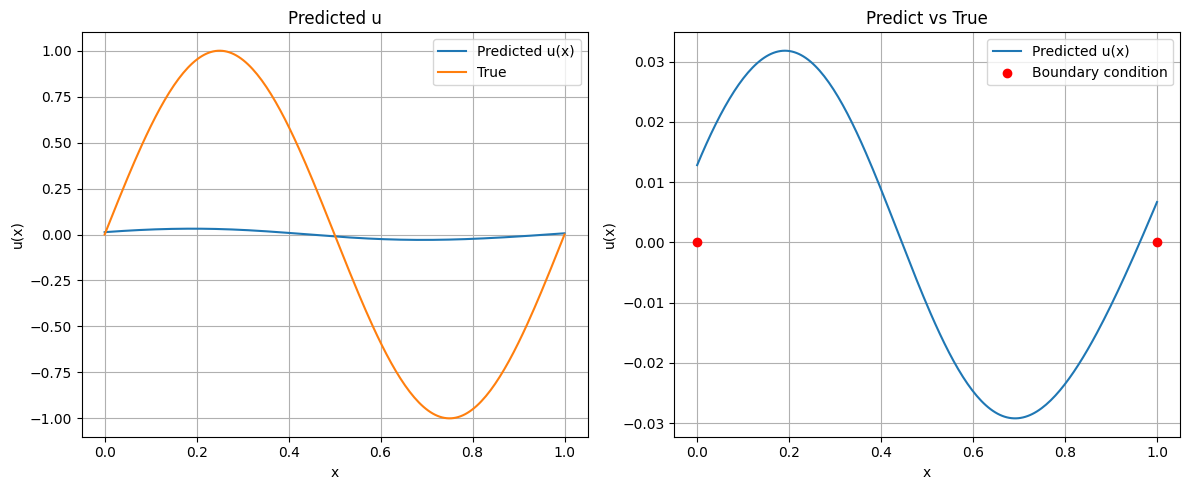

In [2]:
# 학습 결과 시각화
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1행 2열 subplot

# --- 첫 번째 플롯: 예측값만 ---
axes[0].plot(x_test.cpu().numpy(), u_pred, label='Predicted u(x)')
axes[0].plot(x_test.detach().cpu().numpy(), y_true, label='True')
axes[0].set_xlabel("x")
axes[0].set_ylabel("u(x)")
axes[0].set_title("Predicted u")
axes[0].legend()
axes[0].grid(True)

# --- 두 번째 플롯: 예측값 + 정답값 ---
axes[1].plot(x_test.cpu().numpy(), u_pred, label='Predicted u(x)')
axes[1].scatter([0, 1], [0, 0], color='red', label='Boundary condition', zorder=5)
axes[1].set_xlabel("x")
axes[1].set_ylabel("u(x)")
axes[1].set_title("Predict vs True")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [3]:
# Hard constraint 신경망
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return x*(x-1)*self.layers(x) # Hard constraint


# 학습

net = Net()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

for epoch in range(10000):
    x_interior = torch.linspace(0, 1, 100).view(-1, 1)
    x_interior = x_interior[1:-1]  # 내부점만 사용

    # PDE loss
    residual = pde_residual(net, x_interior)
    loss_pde = torch.mean(residual**2)

    # 경계 조건은 신경망에 강제로 제약했으므로, 따로 Loss 부여하지 않음

    # 데이터 조건
    data_x = torch.tensor([[0.1]])
    data_u = torch.tensor([[0.588]])
    pred_u = net(data_x)
    loss_data = torch.mean((pred_u - data_u)**2)

    # 전체 loss
    loss = loss_pde + loss_data

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")



# 결과 시각화
x_test = torch.linspace(0, 1, 200).view(-1, 1)
u_pred = net(x_test).detach().cpu().numpy()

Epoch 0, Loss: 0.550847
Epoch 500, Loss: 0.344277
Epoch 1000, Loss: 0.325481
Epoch 1500, Loss: 0.255636
Epoch 2000, Loss: 0.129509
Epoch 2500, Loss: 0.057351
Epoch 3000, Loss: 0.019989
Epoch 3500, Loss: 0.005675
Epoch 4000, Loss: 0.001299
Epoch 4500, Loss: 0.000931
Epoch 5000, Loss: 0.000298
Epoch 5500, Loss: 0.000252
Epoch 6000, Loss: 0.000223
Epoch 6500, Loss: 0.000194
Epoch 7000, Loss: 0.000174
Epoch 7500, Loss: 0.000202
Epoch 8000, Loss: 0.000143
Epoch 8500, Loss: 0.000183
Epoch 9000, Loss: 0.001310
Epoch 9500, Loss: 0.000107


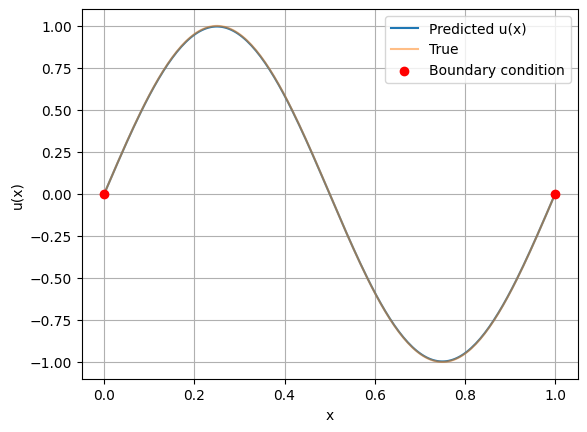

In [4]:
# Hard constraint 신경망 결과 시각화
plt.plot(x_test.detach().cpu().numpy(), u_pred, label='Predicted u(x)')
plt.plot(x_test.detach().cpu().numpy(), y_true, alpha = 0.5, label='True')
plt.scatter([0, 1], [0, 0], color='red', label='Boundary condition', zorder=5)
plt.xlabel("x")
plt.ylabel("u(x)")
plt.legend()
plt.grid(True)
plt.show()